# Regression

## Objectives

* To build and evaluate predictive models that accurately estimate house sale prices in Ames, Iowa, helping Lydia Doe make informed pricing decisions for her inherited properties.


## Inputs

* outputs/datasets/cleaned/house_prices_cleaned.csv
* Target variable: `SalePrice`

## Outputs

* Trained regression models
* Model evaluation metrics (R², MAE, RMSE)
* Actual vs Predicted visualizations
* Best-performing saved model



---

# Change working directory

In [20]:
import os 

project_root = "/workspaces/milestone-project-heritage-housing-issues"
os.chdir(project_root)

print("Current working directory set to:")
print(os.getcwd())

Current working directory set to:
/workspaces/milestone-project-heritage-housing-issues


---

# Load Data

In [21]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/cleaned/house_prices_cleaned.csv")
      .drop(labels=['EnclosedPorch', 'WoodDeckSF'], axis=1)
      # variables we will not need for this project
      # we will not need Churn since it has only 1
      )

print(df.shape)
df.head(3)


(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500


## Import Required Libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

# MP Pipeline: Regressor

## Create ML pipeline

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

# Custom Class for hyperparameter optimisation

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches



## Split Train Test Set

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [25]:
# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [26]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 

Check results

In [27]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.672712,0.804695,0.874444,0.07442
2,RandomForestRegressor,0.632989,0.785848,0.85964,0.08142
0,LinearRegression,0.700438,0.783795,0.819273,0.044047
5,GradientBoostingRegressor,0.635656,0.754929,0.850056,0.085652
4,AdaBoostRegressor,0.621051,0.727258,0.794948,0.066443
6,XGBRegressor,0.516199,0.711484,0.828932,0.112389
1,DecisionTreeRegressor,0.495511,0.63295,0.726995,0.077708


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10,None],
    }
}

Extensive GridSearch CV

In [29]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)

/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 

Check results

In [30]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
7,GradientBoostingRegressor,0.668948,0.766232,0.850032,0.07875,0.01,3,300
0,GradientBoostingRegressor,0.635656,0.754929,0.850056,0.085652,0.1,3,100
1,GradientBoostingRegressor,0.627949,0.741072,0.825227,0.079915,0.1,3,300
9,GradientBoostingRegressor,0.569657,0.731759,0.837156,0.089336,0.01,10,300
2,GradientBoostingRegressor,0.548797,0.725966,0.823137,0.094328,0.1,10,100
3,GradientBoostingRegressor,0.548598,0.725364,0.822807,0.094218,0.1,10,300
11,GradientBoostingRegressor,0.546619,0.688758,0.796302,0.084754,0.01,None,300
4,GradientBoostingRegressor,0.512955,0.674419,0.781933,0.093606,0.1,None,100
5,GradientBoostingRegressor,0.512936,0.674411,0.781926,0.093611,0.1,None,300
8,GradientBoostingRegressor,0.613347,0.667288,0.748431,0.044308,0.01,10,100


Check the best model

In [31]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

Parameters for best model

In [32]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.01,
 'model__max_depth': 3,
 'model__n_estimators': 300}

Define the best regressor, based on search

In [33]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingRegressor(random_state=0))),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.01, n_estimators=300,
                                           random_state=0))])

## Assess feature importance

/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 

* These are the 3 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF']


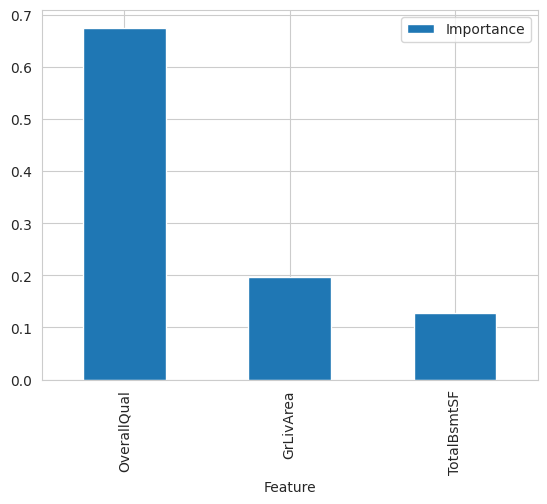

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate on Train and Test Sets

In [35]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.862
Mean Absolute Error: 20885.9
Mean Squared Error: 848097702.071
Root Mean Squared Error: 29122.117


* Test Set
R2 Score: 0.833
Mean Absolute Error: 21925.546
Mean Squared Error: 1152875378.152
Root Mean Squared Error: 33954.019




/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 

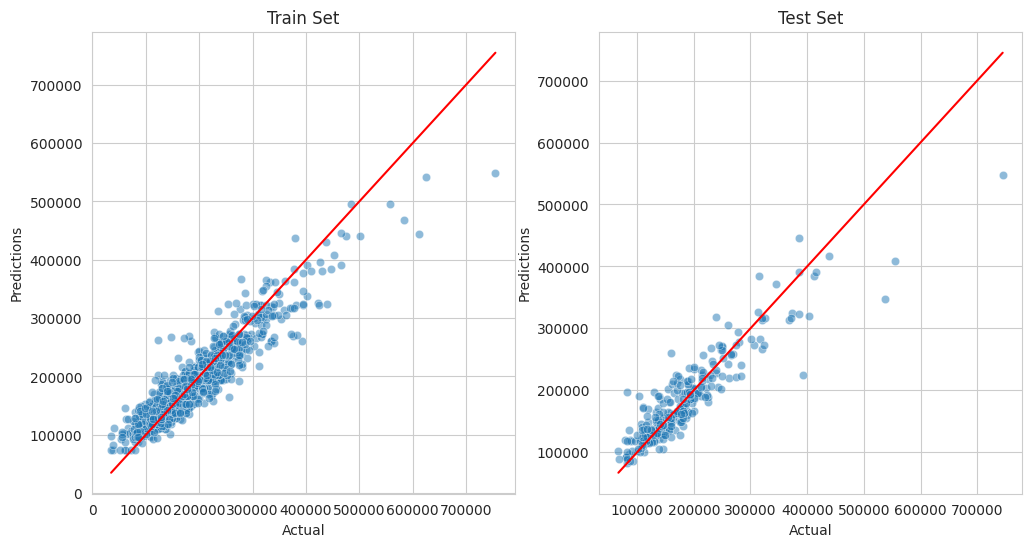

In [36]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

# Regressor with PCA

Let's explore potential values for PCA n_components.

In [38]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:3])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'numpy.ndarray'>


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 

Apply PCA separately to the scaled data

* The 17 components explain 100.0% of the data 



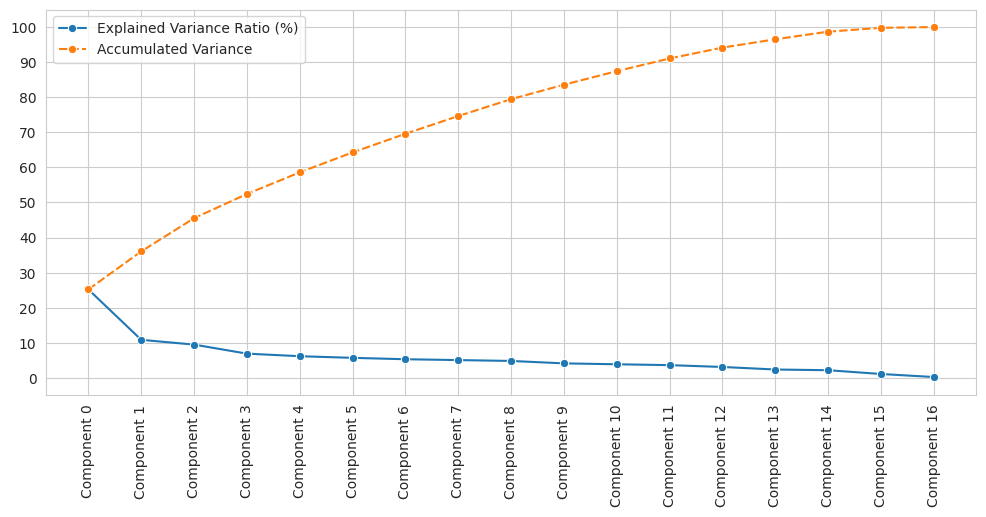

In [39]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 17


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)


* The 8 components explain 74.62% of the data 



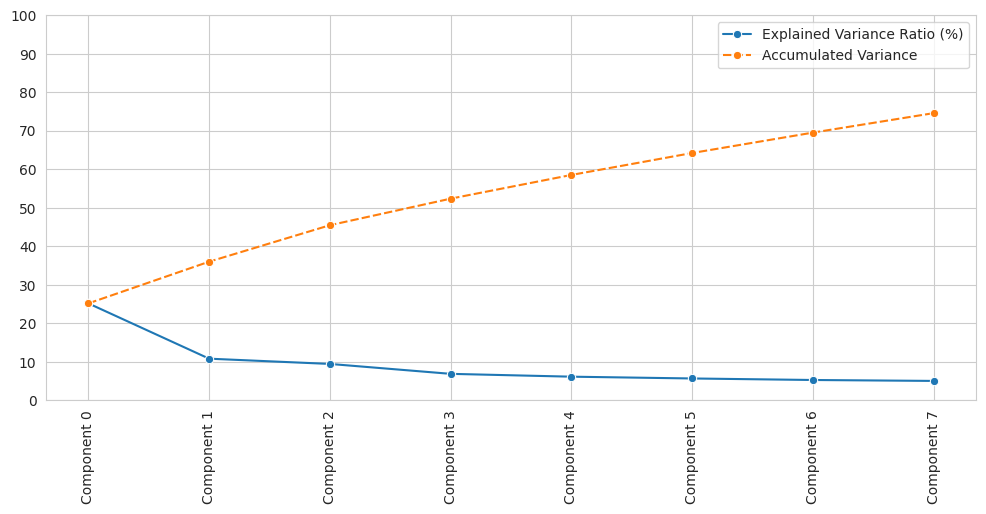

In [41]:
n_components = 8
pca_components_analysis(df_pca=df_pca, n_components=n_components)

## Rewrite ML Pipeline for Modelling

In [42]:
# PCA
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['gender', 'Partner', 'Dependents', 'PhoneService',
                                                                'MultipleLines', 'InternetService', 'OnlineSecurity',
                                                                'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                                                'StreamingTV', 'StreamingMovies', 'Contract',
                                                                'PaperlessBilling', 'PaymentMethod'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),


        ("feat_scaling", StandardScaler()),

        # PCA replace Feature Selection
        ("PCA", PCA(n_components=7, random_state=0)),

        ("model", model),

    ])

    return pipeline_base


## Grid Search CV – Sklearn

In [43]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


### Use standard hyperparameters to find the most suitable model.

In [44]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}


Do a quick optimisation search 

In [45]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py", line 919, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/ordinal.py", line 201, in fit
    variables_ = self._check_or_select_variables(X)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py", line 135, in _check_or_select_variables
    variables_: List[Union[str, int]] = find_or_check_categorical_variables(
                                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/variable_handling/variable_type_selection.py", line 156, in find_or_check_categorical_variables
    if len(X[variables].select_dtypes(exclude=["O", "category"]).columns) > 0:
           ~^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/pandas/core/frame.py", line 3902, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/pandas/core/indexes/base.py", line 6114, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File "/home/cistudent/.local/lib/python3.12/site-packages/pandas/core/indexes/base.py", line 6175, in _raise_if_missing
    raise KeyError(f"None of [{key}] are in the [{axis_name}]")
KeyError: "None of [Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',\n       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',\n       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',\n       'PaperlessBilling', 'PaymentMethod'],\n      dtype='object')] are in the [columns]"


Check results

In [ ]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.415101,0.465572,0.509798,0.032533
0,LinearRegression,0.366761,0.427524,0.49016,0.044923
2,RandomForestRegressor,0.369395,0.415739,0.462457,0.033631
3,ExtraTreesRegressor,0.333684,0.362562,0.394701,0.024291
6,XGBRegressor,0.252028,0.326347,0.368255,0.039709
4,AdaBoostRegressor,0.225752,0.267553,0.303847,0.033549
1,DecisionTreeRegressor,-0.055877,0.05544,0.15696,0.083794


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters for extensive search

In [ ]:
models_search = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "GradientBoostingRegressor":{
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10, None],
    }
}

Extensive GridSearch CV

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
0,GradientBoostingRegressor,0.415101,0.465572,0.509798,0.032533,0.1,3,100
7,GradientBoostingRegressor,0.394502,0.448338,0.497221,0.034659,0.01,3,300
1,GradientBoostingRegressor,0.369578,0.429438,0.482433,0.038361,0.1,3,300
9,GradientBoostingRegressor,0.299338,0.348577,0.430934,0.051925,0.01,10,300
8,GradientBoostingRegressor,0.291393,0.339118,0.412556,0.047216,0.01,10,100
6,GradientBoostingRegressor,0.28988,0.332975,0.370785,0.028765,0.01,3,100
2,GradientBoostingRegressor,0.275639,0.309743,0.395497,0.044079,0.1,10,100
3,GradientBoostingRegressor,0.262741,0.296374,0.380407,0.042892,0.1,10,300
10,GradientBoostingRegressor,0.193489,0.278846,0.351687,0.051477,0.01,None,100
17,GradientBoostingRegressor,0.170848,0.200545,0.238893,0.023648,0.001,None,300


Check the best model

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

Parameters for best model

In [ ]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 100}

Define the best regressor

In [ ]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'Partner', 'Dependents',
                                           'PhoneService', 'MultipleLines',
                                           'InternetService', 'OnlineSecurity',
                                           'OnlineBackup', 'DeviceProtection',
                                           'TechSupport', 'StreamingTV',
                                           'StreamingMovies', 'Contract',
                                           'PaperlessBilling',
                                           'PaymentMethod'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('PCA', PCA(n_components=7, random_state=0)),
                ('model', GradientBoostingRegressor(random_state=0))])

## Evaluate Regressor on Train and Tests Sets

Model Evaluation 

* Train Set
R2 Score: 0.668
Mean Absolute Error: 8.404
Mean Squared Error: 126.248
Root Mean Squared Error: 11.236


* Test Set
R2 Score: 0.525
Mean Absolute Error: 10.21
Mean Squared Error: 182.211
Root Mean Squared Error: 13.499




/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 

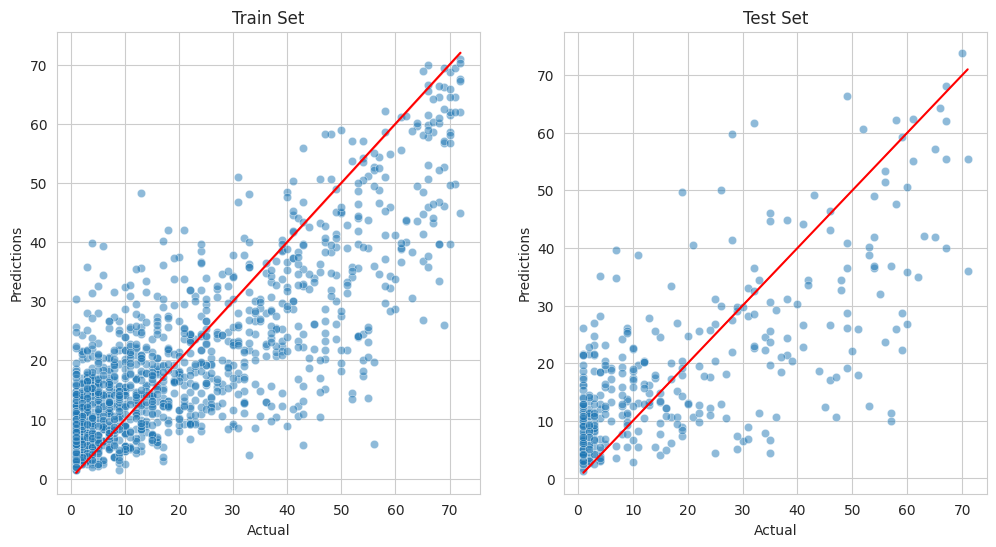

In [ ]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

# Convert Regression to Classification

### Convert numerical target to bins, and check if it is balanced

* The classes represent the following ranges: 
{'tenure': [-inf, 4.0, 20.0, inf]} 



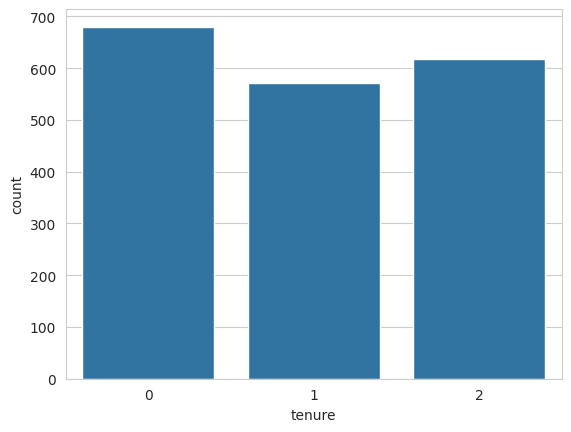

In [ ]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
disc = EqualFrequencyDiscretiser(q=3, variables=['SalePrice'])
df_clf = disc.fit_transform(df)

print(f"* The classes represent the following ranges: \n{disc.binner_dict_} \n")
sns.countplot(data=df_clf, x='SalePrice')
plt.show()

In [ ]:
df_clf.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
2,Male,0,No,No,0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85
4,Female,0,No,No,0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70
5,Female,0,No,No,1,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65


## Rewrite ML Pipeline for Modelling

In [ ]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base


## Load algorithms for classification

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

## Split Train Test Sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['tenure'], axis=1),
    df_clf['tenure'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1495, 17) (1495,) 
* Test set: (374, 17) (374,)


## Grid Seach CV – Sklearn

### Use standard hyper parameters to find most suitable model

In [ ]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

GridSearch CV

In [ ]:
from sklearn.metrics import make_scorer, recall_score
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train,
                 scoring = make_scorer(recall_score, labels=[0], average=None),
                 n_jobs=-1,
                 cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 


Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 


Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,AdaBoostClassifier,0.71028,0.74306,0.785047,0.025691
3,GradientBoostingClassifier,0.654206,0.70019,0.766355,0.042231
0,XGBClassifier,0.537037,0.674386,0.88785,0.11565
1,DecisionTreeClassifier,0.551402,0.607061,0.700935,0.053403
4,ExtraTreesClassifier,0.514019,0.577224,0.64486,0.04534
2,RandomForestClassifier,0.504673,0.560471,0.64486,0.052707


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define models and parameters

In [ ]:
models_search = {
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

# documentation to help on hyperparameter list:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
params_search = {
    "AdaBoostClassifier": {
        'model__n_estimators': [50, 100, 300],
        'model__learning_rate': [1e-1, 1e-2, 1e-3],
    }
}


Extensive GridSearch CV

In [ ]:
from sklearn.metrics import make_scorer,  recall_score
search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring=make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1, cv=5)



Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__n_estimators
6,AdaBoostClassifier,0.757009,0.87712,0.971963,0.076554,0.001,50
7,AdaBoostClassifier,0.757009,0.867861,0.971963,0.073967,0.001,100
8,AdaBoostClassifier,0.757009,0.826739,0.87037,0.039713,0.001,300
3,AdaBoostClassifier,0.757009,0.796971,0.814815,0.020399,0.01,50
4,AdaBoostClassifier,0.757009,0.795102,0.814815,0.02012,0.01,100
5,AdaBoostClassifier,0.757009,0.783956,0.805556,0.018387,0.01,300
0,AdaBoostClassifier,0.757009,0.770976,0.803738,0.01693,0.1,50
1,AdaBoostClassifier,0.728972,0.763499,0.803738,0.024069,0.1,100
2,AdaBoostClassifier,0.703704,0.741243,0.785047,0.027649,0.1,300



Check the best model

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

Parameters for best model
* We are saving this content for later

In [ ]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.001, 'model__n_estimators': 50}

Define the best clf pipeline

In [ ]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'Partner', 'Dependents',
                                           'PhoneService', 'MultipleLines',
                                           'InternetService', 'OnlineSecurity',
                                           'OnlineBackup', 'DeviceProtection',
                                           'TechSupport', 'StreamingTV',
                                           'StreamingMovies', 'Contract',
                                           'PaperlessBilling',
                                           'PaymentMethod'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model',
                 AdaBoostClassifier(learning_rate=0.001, random_state=0))])

## Assess feature importance

We can assess feature importance for this model with `.feature_importances_`

* These are the 3 most important features in descending order. The model was trained on them: 
['MonthlyCharges', 'Contract', 'PaymentMethod']


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 

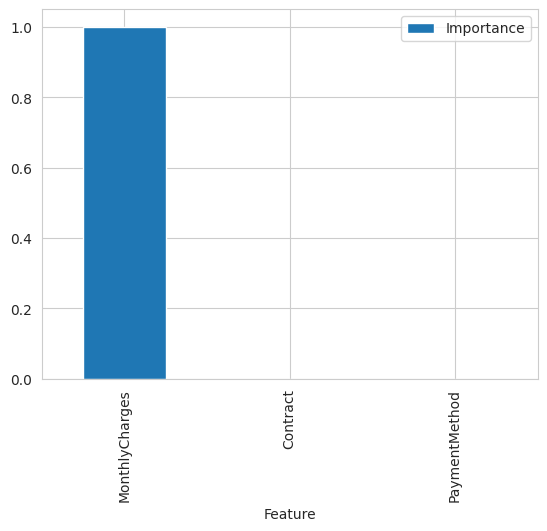

In [ ]:
# after data cleaning and feat engine, the feature may space changes
# how much data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features = columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Classifier on Train and Test Sets

Custom Function

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


List that relates the classes and tenure interval

In [ ]:
disc.binner_dict_['SalePrice']

[-inf, 4.0, 20.0, inf]

We can create manually

In [ ]:
label_map = ['Low', 'Medium', 'High']
label_map

['<4.0', '4.0 to 20.0', '+20.0']

In [ ]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                       Actual <4.0 Actual 4.0 to 20.0 Actual +20.0
Prediction <4.0                432                234          157
Prediction 4.0 to 20.0           5                 11            4
Prediction +20.0               100                222          330


---  Classification Report  ---
              precision    recall  f1-score   support

        <4.0       0.52      0.80      0.64       537
 4.0 to 20.0       0.55      0.02      0.05       467
       +20.0       0.51      0.67      0.58       491

    accuracy                           0.52      1495
   macro avg       0.53      0.50      0.42      1495
weighted avg       0.53      0.52      0.43      1495
 

#### Test Set ####

---  Confusion Matrix  ---
                       Actual <4.0 Actual 4.0 to 20.0 Actual +20.0
Prediction <4.0                115                 48           34
Prediction 4.0 to 20.0           2                  1            0
Prediction +20.0  

/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 

# Which pipeline to choose?

We fitted 3 pipelines:
* Regression
* Regression with PCA
* Classifier

The regressor pipelines didn't reach the expected performance threshold (0.7 R2 score) for the train and test set.

The classifier was tuned on Recall for class 0 (tenure <4 months), since we are interested to detect prospects that may churn soon. 
* It has reasonable performance for class 0 (<4 months) and class 2 (+20 months)
* Class 1 (4 to 20 months) has weak performance.

In [ ]:
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'Partner', 'Dependents',
                                           'PhoneService', 'MultipleLines',
                                           'InternetService', 'OnlineSecurity',
                                           'OnlineBackup', 'DeviceProtection',
                                           'TechSupport', 'StreamingTV',
                                           'StreamingMovies', 'Contract',
                                           'PaperlessBilling',
                                           'PaymentMethod'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model',
                 AdaBoostClassifier(learning_rate=0.001, random_state=0))])

# Refit pipeline with best features

## Rewrite Pipeline

In [ ]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Contract', 'PaymentMethod'])),

        ("feat_scaling", StandardScaler()),

        # feature selection is not needed

        ("model", model),

    ])

    return pipeline_base


## Split Train Test Set, only with best features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['SalePrice'], axis=1),
    df_clf['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1495, 17) (1495,) 
* Test set: (374, 17) (374,)


Subset Best Features

In [ ]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1495, 3) (1495,) 
* Test set: (374, 3) (374,)


,MonthlyCharges,Contract,PaymentMethod
5779,95.55,One year,Electronic check
2608,34.50,Month-to-month,Electronic check
2464,77.15,Month-to-month,Electronic check


## Grid Search CV – Sklearn

We are using the same model from the previous GridCV search

In [ ]:
models_search

{'AdaBoostClassifier': AdaBoostClassifier(random_state=0)}

And the best parameters from the previous GridCV search

In [ ]:
best_parameters

{'model__learning_rate': 0.001, 'model__n_estimators': 50}

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [ ]:
params_search = {'AdaBoostClassifier':  {
    'model__learning_rate': [0.001],   # the value should be in []
    'model__n_estimators': [50]       # the value should be in []
}
}
params_search

{'AdaBoostClassifier': {'model__learning_rate': [0.001],
  'model__n_estimators': [50]}}

GridSearch CV

In [ ]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1,cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 


Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__n_estimators
0,AdaBoostClassifier,0.757009,0.87712,0.971963,0.076554,0.001,50


Check the best model

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

Define the best clf pipeline

In [ ]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Contract', 'PaymentMethod'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 AdaBoostClassifier(learning_rate=0.001, random_state=0))])

## Assess feature importance

/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):


* These are the 3 most important features in descending order. The model was trained on them: 
['MonthlyCharges', 'Contract', 'PaymentMethod']


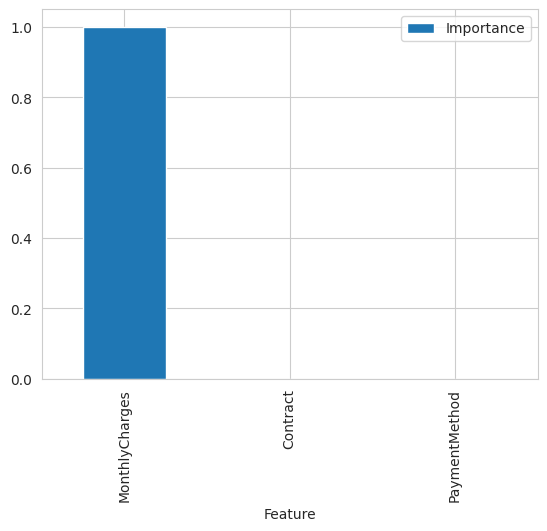

In [ ]:
# how many data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Classifier on Train and Test Sets

In [ ]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                       Actual <4.0 Actual 4.0 to 20.0 Actual +20.0
Prediction <4.0                432                234          157
Prediction 4.0 to 20.0           5                 11            4
Prediction +20.0               100                222          330


---  Classification Report  ---
              precision    recall  f1-score   support

        <4.0       0.52      0.80      0.64       537
 4.0 to 20.0       0.55      0.02      0.05       467
       +20.0       0.51      0.67      0.58       491

    accuracy                           0.52      1495
   macro avg       0.53      0.50      0.42      1495
weighted avg       0.53      0.52      0.43      1495
 

#### Test Set ####

---  Confusion Matrix  ---
                       Actual <4.0 Actual 4.0 to 20.0 Actual +20.0
Prediction <4.0                115                 48           34
Prediction 4.0 to 20.0           2                  1            0
Prediction +20.0  

/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 

# Push files to the repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* label map
* features importance plot

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_tenure/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set: features and target

In [ ]:
X_train.head()

,MonthlyCharges,Contract,PaymentMethod
5779,95.55,One year,Electronic check
2608,34.50,Month-to-month,Electronic check
2464,77.15,Month-to-month,Electronic check
4149,49.35,Two year,Electronic check
6612,69.90,Month-to-month,Mailed check


In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train

5779    2
2608    1
2464    0
4149    2
6612    0
       ..
3188    1
4651    1
6256    0
2101    2
2631    1
Name: tenure, Length: 1495, dtype: int64

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [ ]:
X_test.head()

,MonthlyCharges,Contract,PaymentMethod
2900,69.25,Month-to-month,Electronic check
996,70.00,Month-to-month,Credit card (automatic)
4005,24.05,Month-to-month,Mailed check
334,80.60,Month-to-month,Mailed check
6341,100.35,Month-to-month,Electronic check


In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test

2900    0
996     2
4005    0
334     0
6341    1
       ..
2570    2
2527    1
5186    0
5198    2
710     0
Name: tenure, Length: 374, dtype: int64

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

ML pipeline for predicting tenure

In [ ]:
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Contract', 'PaymentMethod'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 AdaBoostClassifier(learning_rate=0.001, random_state=0))])

In [ ]:
joblib.dump(value=pipeline_clf, filename=f"{file_path}/clf_pipeline.pkl")

['outputs/ml_pipeline/predict_tenure/v1/clf_pipeline.pkl']

## List  mapping target levels to ranges

Map for converting numerical variable to categorical variable

In [ ]:
label_map

['<4.0', '4.0 to 20.0', '+20.0']

In [ ]:
joblib.dump(value=label_map, filename=f"{file_path}/label_map.pkl")

['outputs/ml_pipeline/predict_tenure/v1/label_map.pkl']

## Feature importance plot

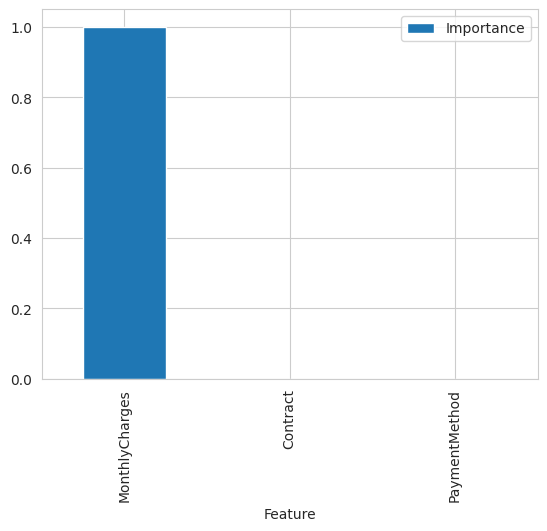

In [ ]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

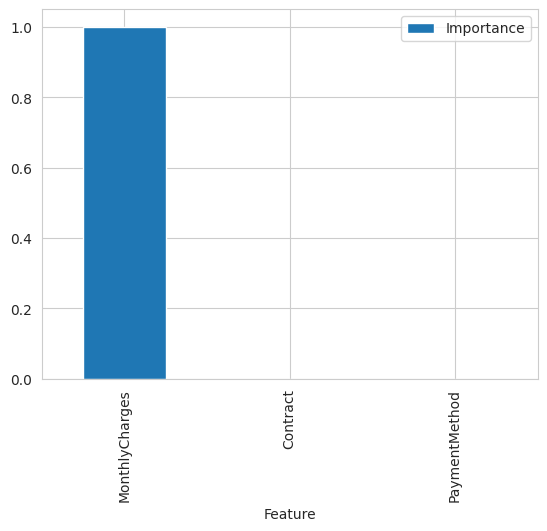

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

Good job! Clear cell's outputs, push to the repo using git commands and move on to the next notebook

---